In [3]:
import math
import numpy as np
from scipy.sparse import coo_matrix, vstack, identity
import scipy.sparse.linalg
import matplotlib.pyplot as plt
from matplotlib import patches
from scipy.ndimage.filters import gaussian_filter

# 2

In [4]:
alphas_77 = np.load("./hs_tomography/alphas_77.npy")
alphas_195 = np.load("./hs_tomography/alphas_195.npy")
y_195 = np.load("hs_tomography/y_195.npy", allow_pickle=True)
y_77 = np.load("hs_tomography/y_77.npy", allow_pickle=True)

In [5]:
def construct_X(M, alphas, Np = None, tau=0):
    Np = Np if Np else math.ceil(math.sqrt(2) * M)
    No = alphas.shape[0]    # Number of orientations
    N =  No * Np            # flattened array length of intensitie measurements
    D = M * M               # flattened array length of tomogram

    # Compute two indices a and b for each pixel
    ja = np.mgrid[0:D] % M
    jb = (np.mgrid[0:D] - ja) / M

    C = np.array([ja, jb])

    # Move pixels such that the middle pixel (M/2, M/2) is in the origin of the coordinate system
    C_moved = C - np.array([[M / 2],[M / 2]])

    all_weights = []
    all_i_indices = []
    all_j_indices = []

    for io in range(No):

        alpha = np.radians(alphas[io])
        # Calculate unit vector in direction of sensor array using 2D rotation matrix
        # negate the y value, as coordinate system goes the "opposite" direction
        n = np.array([[math.cos(alpha)], [-math.sin(alpha)]])
        p = np.dot(n.T, C_moved) 

        p = p[0]

        # Center of sensor array is at origin => add half the length of the sensor array
        p = p + Np / 2

        # Calculate index of the two sensors
        idx_sensor1 = np.floor(p) + Np * io
        idx_sensor2 = np.ceil(p) + Np * io

        # Calculate the weights of the two sensors
        weight2 = p - np.floor(p)
        weight1 = 1 - weight2

        # Calculate the index of the pixels
        idx_pixel1 = np.mgrid[0:D]
        idx_pixel2 = np.mgrid[0:D]

        weights = np.append(weight1, weight2)
        idx_sensor = np.append(idx_sensor1, idx_sensor2)
        idx_pixel = np.append(idx_pixel1, idx_pixel2)

        all_weights.extend(weights)
        all_j_indices.extend(idx_pixel)
        all_i_indices.extend(idx_sensor)


    all_weights = np.array(all_weights)
    all_i_indices = np.array(all_i_indices)
    all_j_indices = np.array(all_j_indices)

    X = coo_matrix((all_weights, (all_i_indices, all_j_indices)), shape=(N, D), dtype = np.float32)

    # regularization
    if(tau): X = vstack([X, identity(D) * math.sqrt(tau)])

    return X

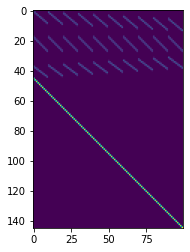

In [6]:
# verify construct_M
X_small = construct_X(M=10, alphas=np.array([-33, 1, 42]), Np=15, tau=10)
plt.imshow(X_small.todense())
plt.show()

In [7]:
def reconstruct_image(X, y, tolerance):
    X = scipy.sparse.csc_matrix(X)
    beta, solution, *_ = scipy.sparse.linalg.lsqr(X, y, atol=tolerance, btol=tolerance)
    
    if solution != 1:
        print("system could only be solved by minimizing squared errors")

    return beta

In [8]:
def test_regularization(y, tolerance, M, alphas, Np, tau, alphasize):
    fig, ax = plt.subplots()
    alphas = alphas[:alphasize]
    y = y[0:Np*alphasize]
    X = construct_X(M, alphas, Np, tau)
    if(tau):
        y = np.append(y, np.zeros(M*M))
    beta = reconstruct_image(X, y, tolerance)
    img = beta.reshape((M, M))

    ax.imshow(img)
    ax.add_patch(patches.Rectangle((120, 40), 30, 80, angle=60, linewidth=1, edgecolor='r', facecolor='none'))
    plt.show()


Note, that the image looks distorted because the size of alpha was limited to 64 angles, as required by the exercise. 

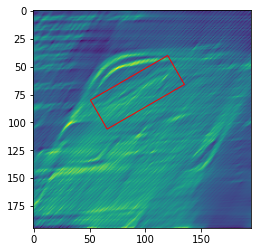

In [9]:
test_regularization(y=y_195, tolerance=3e-3, M=195, alphas=alphas_195, Np=275, tau=0, alphasize=64)

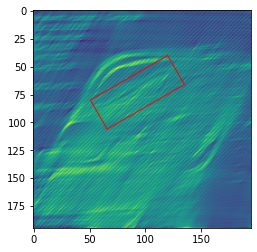

In [10]:
test_regularization(y=y_195, tolerance=3e-3, M=195, alphas=alphas_195, Np=275, tau=1, alphasize=64)

system could only be solved by minimizing squared errors


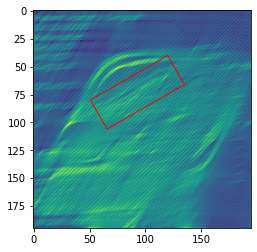

In [11]:
test_regularization(y=y_195, tolerance=3e-3, M=195, alphas=alphas_195, Np=275, tau=10, alphasize=64)

system could only be solved by minimizing squared errors


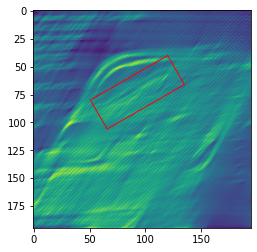

In [12]:
test_regularization(y=y_195, tolerance=3e-3, M=195, alphas=alphas_195, Np=275, tau=100, alphasize=64)

system could only be solved by minimizing squared errors


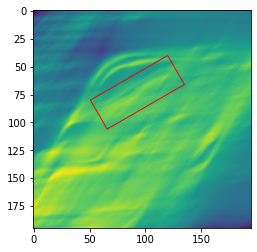

In [13]:
test_regularization(y=y_195, tolerance=3e-3, M=195, alphas=alphas_195, Np=275, tau=1000, alphasize=64)

system could only be solved by minimizing squared errors


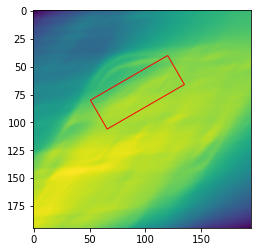

In [14]:
test_regularization(y=y_195, tolerance=3e-3, M=195, alphas=alphas_195, Np=275, tau=10000, alphasize=64)

In [15]:
def test_gaussian_filter(y, tolerance, M, alphas, Np, sigma, alphasize):
    fig, ax = plt.subplots()
    alphas = alphas[:alphasize]
    y = y[0:Np*alphasize]
    X = construct_X(M, alphas, Np)

    beta = reconstruct_image(X, y, tolerance)
    img = beta.reshape((M, M))

    img = gaussian_filter(img, sigma)

    ax.imshow(img)
    ax.add_patch(patches.Rectangle((120, 40), 30, 80, angle=60, linewidth=1, edgecolor='r', facecolor='none'))
    plt.show()


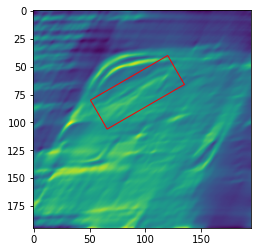

In [16]:
test_gaussian_filter(y=y_195, tolerance=3e-3, M=195, alphas=alphas_195, Np=275, sigma=1, alphasize=64)

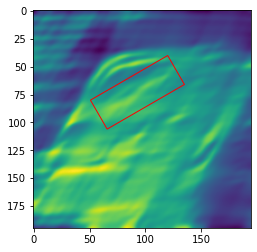

In [17]:
test_gaussian_filter(y=y_195, tolerance=3e-3, M=195, alphas=alphas_195, Np=275, sigma=2, alphasize=64)

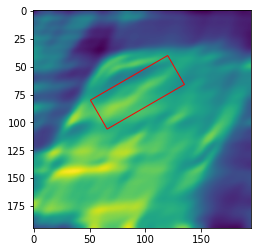

In [18]:
test_gaussian_filter(y=y_195, tolerance=3e-3, M=195, alphas=alphas_195, Np=275, sigma=3, alphasize=64)

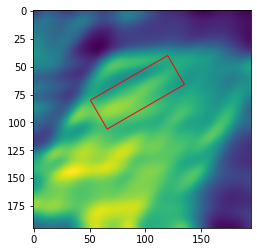

In [19]:
test_gaussian_filter(y=y_195, tolerance=3e-3, M=195, alphas=alphas_195, Np=275, sigma=5, alphasize=64)

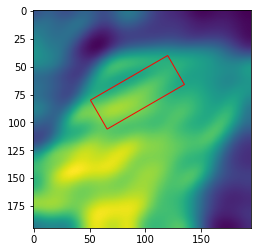

In [20]:
test_gaussian_filter(y=y_195, tolerance=3e-3, M=195, alphas=alphas_195, Np=275, sigma=7, alphasize=64)

In [21]:
from scipy.linalg import lstsq

In [184]:
def omp_regression(X, y, T, tolerance=3e-3):
    D = X.shape[1]
    N = X.shape[0]
    X_inactive = X
    X_active = np.array([])
    j_current = None
    r_current = y
    A = np.array([], dtype=int)
    B = np.mgrid[0:D]
    solution = np.zeros((T, D))
    for t in range(T):
        j_current = np.argmax(X_inactive.T.dot(r_current))
        A = np.append(A, j_current)
        B = B[B != j_current]
        print(j_current)
        
        X_active = np.zeros((N,D))
        X_active[:,A] = X[:,A]

        X_inactive = np.zeros((N,D))
        X_inactive[:,B] = X[:,B]

        beta, *_ = lstsq(X_active, y)
        r_current = y - X_active.dot(beta)
        np.put(solution[t], np.sort(A), beta)
    return solution

In [23]:
from sklearn.datasets import load_digits

In [24]:
digits = load_digits()
data = digits["data"]
images = digits["images"]
target = digits["target"]
target_names = digits["target_names"]

In [25]:
one = (target == 1) * 1
seven = (target == 7) * -1
y = one + seven

In [185]:
beta = omp_regression(data, y, 30)

19
63
55
16
24
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


In [173]:
beta[5]

array([-1.28516891e-18,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  1.00613962e-15,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
       -3.36536354e-16,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  

In [134]:
beta[0].shape

(64,)

In [133]:
data.shape

(1797, 64)

In [166]:
np.sum(y - data.dot(beta[29]))

3.0